# Imports

In [34]:
# !pip install --upgrade transformers==4.49.0
# !pip install optuna==2.10.0
# !pip install numpy==1.26.4 gensim==4.3.2
# !pip install scipy==1.12.0
# !pip install --upgrade pandas==2.2.2
# !pip install h3
# !pip install mlflow
# !pip install 'protobuf<4'
# !pip install selenium
# !pip install natasha
# !pip install pymystem3
# !pip install symspellpy
# !pip install nvidia-ml-py3
!rm -rf /content/Price-prediction-with-textual-data # для переустановки репозитория необходимо его сначала сбросить

In [35]:
!git clone https://github.com/anna-k-00/Price-prediction-with-textual-data.git

Cloning into 'Price-prediction-with-textual-data'...
remote: Enumerating objects: 439, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 439 (delta 79), reused 6 (delta 6), pack-reused 303 (from 2)
Receiving objects: 100% (439/439), 2.20 MiB | 21.48 MiB/s, done.
Resolving deltas: 100% (227/227), done.


In [20]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [36]:
# Шаг 1: Проверка и настройка окружения
import os
import sys
import importlib

# Шаг 2: Клонирование/обновление репозитория
repo_url = 'https://github.com/anna-k-00/Price-prediction-with-textual-data.git'
repo_dir = 'Price-prediction-with-textual-data'

if not os.path.exists(repo_dir):
    !git clone {repo_url}
else:
    !cd {repo_dir} && git pull

# Шаг 3: Добавляем все нужные пути в sys.path
paths_to_add = [
    f'/content/{repo_dir}',                     # Для файлов в корне (parser_avito.py)
    f'/content/{repo_dir}/main_methods',        # Основные модули
    f'/content/{repo_dir}/embeddings_generation', # Генерация эмбеддингов
    f'/content/{repo_dir}/preprocessors'        # Препроцессоры
]

for path in paths_to_add:
    if os.path.exists(path) and path not in sys.path:
        sys.path.insert(0, path)
        print(f'Добавлен путь: {path}')

# Шаг 4: Собираем список всех модулей для импорта
all_modules = [
    # Основные модули
    'resource_monitor', 'ann', 'predict', 'test_pipeline',

    # Модули из embeddings_generation
    'embeddings_generation.rubert_transformer',
    'embeddings_generation.tfidf_transformer',
    'embeddings_generation.w2v_transformer',
    'embeddings_generation.gate',

    # Модули из preprocessors
    'preprocessors.preprocessor_params_hex',
    'preprocessors.preprocessor_text',

    # Отдельные файлы в корне
    'parser_avito'
]

# Шаг 5: Импортируем все модули
imported_modules = {}
failed_modules = {}

for module_name in all_modules:
    try:
        module = importlib.import_module(module_name)
        imported_modules[module_name] = module
        print(f'✅ {module_name} успешно импортирован')
    except Exception as e:
        failed_modules[module_name] = str(e)
        print(f'❌ Ошибка импорта {module_name}: {str(e)[:200]}')  # Обрезаем длинные сообщения

Already up to date.
✅ resource_monitor успешно импортирован
✅ ann успешно импортирован
✅ predict успешно импортирован
✅ test_pipeline успешно импортирован
✅ embeddings_generation.rubert_transformer успешно импортирован
✅ embeddings_generation.tfidf_transformer успешно импортирован
✅ embeddings_generation.w2v_transformer успешно импортирован
✅ embeddings_generation.gate успешно импортирован
✅ preprocessors.preprocessor_params_hex успешно импортирован
✅ preprocessors.preprocessor_text успешно импортирован
✅ parser_avito успешно импортирован


In [37]:
import logging
import os
import time
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import optuna
from optuna.samplers import TPESampler
from tqdm import tqdm
import mlflow
import mlflow.sklearn
import warnings
from transformers import AutoModel, AutoTokenizer, AdamW
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from sklearn.svm import LinearSVR
from sklearn.base import BaseEstimator, TransformerMixin
import random
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
import torch
import torch.nn as nn
import os
import joblib
import transformers
import json
import joblib
from datetime import datetime
from sklearn.decomposition import PCA
import time
import sys
import platform
import psutil
import threading

try:
    import pynvml
    pynvml.nvmlInit()
    HAS_NVML = True
except Exception:
    HAS_NVML = False

from ann import ANNRegressor
from resource_monitor import ResourceMonitor
from test_pipeline import PricePredictionExperiment
from preprocessor_params_hex import DataProcessingPipeline

from tfidf_transformer import TfidfTransformer
from w2v_transformer import Word2VecTransformer
from rubert_transformer import RuBertTiny2Embedder

# Prediction

### Mount at shared ML flow

самый простой способ получить доступ к нашему архиву ml flow - по ссылке 'https://drive.google.com/drive/folders/195Ie1O3SPhwsoMSiLTUydNI-9Tf_QnU7'

через интерфейс Google Drive:

- Перейдите по нашей ссылке будучи авторизованными (доступы уже открыты)
- Откройте Google Drive
- Найдите папку в разделе "Доступно мне" (Shared with me)
- Правой кнопкой мыши → "Добавить ярлык на Диск" (Add shortcut to Drive)
- Выберите расположение в "Мой диск" → Нажмите "Добавить"

In [23]:
# после добавление шортката можно просто напрямую подключаться к папке - все результаты наших экспериментов уже у вас на диске
mlflow.set_tracking_uri('file:///content/drive/My Drive/mlflow_data')

### Download model

класс PricePredictorMLflow работает с моделями, лежащими в ml flow (со всеми их вариантами, которые можно сохранить во всех вариантах эксперимента)
он может найти для вас нужную модель и все связанные архивы
- либо по run_id (быстро)
- либо по param_filters смотря на лучший r^2 или на последний run - смотря что выберете

поскольку мы знаем, какая модель лучшая и знаем ее run_id - заберем ее

In [24]:
# лучшая XGBoost
predictor_base = PricePredictorMLflow(
    experiment_name="price_prediction",
    param_filters={
        "feature_set": "categorical-only",
        "use_pca": "False",
        'use_gate': 'False',
        'manual_text_params':'False',
    },
    run_id = 'd5df1a361ca244bd8d58886736a195f9', # для поиска по run id указывать параметры не обязательно, это пример для наглядности - в режиме false модель будет искаться по параметрам
    use_run_id = True,
    model_class=PricePredictionExperiment
)

[MLFLOW] full_model: OK


[MLFLOW] params: OK


[MLFLOW] preprocessing: OK


[MLFLOW] transformer: нет (The following failures occurred while downloading one or more artifacts from file:///content/drive/My Drive/mlflow_data/209504058848569233/d5df1a361ca244bd8d58886736a195f9/artifacts:
##### File transformer #####
[Errno 2] No such file or directory: '/content/drive/My Drive/mlflow_data/209504058848569233/d5df1a361ca244bd8d58886736a195f9/artifacts/transformer')


[MLFLOW] tokenizer: нет (The following failures occurred while downloading one or more artifacts from file:///content/drive/My Drive/mlflow_data/209504058848569233/d5df1a361ca244bd8d58886736a195f9/artifacts:
##### File tokenizer #####
[Errno 2] No such file or directory: '/content/drive/My Drive/mlflow_data/209504058848569233/d5df1a361ca244bd8d58886736a195f9/artifacts/tokenizer')


[MLFLOW] : OK
[LOAD] pipeline: OK
[LOAD] params: OK
[LOAD] preprocessing: OK
[LOAD] transformer не удалось загрузить!
[BUNDLE] pipeline: <class 'sklearn.pipeline.Pipeline'>
[BUNDLE] transformer: <class 'NoneType'>
[BUNDLE] tokenizer: <class 'NoneType'>
[BUNDLE] params: True
[BUNDLE] preprocessing: True
Loaded manual_text_params from params: 0
Converted to bool: False
[INFO] Model loaded successfully - feature_set: categorical-only, embedding: None, manual_text_params: False


In [25]:
# модель XGBoost с ручными текстовыми фичами
predictor_mtf = PricePredictorMLflow(
    experiment_name="price_prediction",
    param_filters={
        "feature_set": "categorical-only",
        "use_pca": "False",
        'use_gate': 'False',
        'manual_text_params':'True',
    },
    run_id = '96821250b16145b3a3e6d0c0c4268ca1',
    use_run_id = True,
    model_class=PricePredictionExperiment
)

[MLFLOW] full_model: OK


[MLFLOW] params: OK


[MLFLOW] preprocessing: OK


[MLFLOW] transformer: нет (The following failures occurred while downloading one or more artifacts from file:///content/drive/My Drive/mlflow_data/209504058848569233/96821250b16145b3a3e6d0c0c4268ca1/artifacts:
##### File transformer #####
[Errno 2] No such file or directory: '/content/drive/My Drive/mlflow_data/209504058848569233/96821250b16145b3a3e6d0c0c4268ca1/artifacts/transformer')


[MLFLOW] tokenizer: нет (The following failures occurred while downloading one or more artifacts from file:///content/drive/My Drive/mlflow_data/209504058848569233/96821250b16145b3a3e6d0c0c4268ca1/artifacts:
##### File tokenizer #####
[Errno 2] No such file or directory: '/content/drive/My Drive/mlflow_data/209504058848569233/96821250b16145b3a3e6d0c0c4268ca1/artifacts/tokenizer')


[MLFLOW] : OK
[LOAD] pipeline: OK
[LOAD] params: OK
[LOAD] preprocessing: OK
[LOAD] transformer не удалось загрузить!
[BUNDLE] pipeline: <class 'sklearn.pipeline.Pipeline'>
[BUNDLE] transformer: <class 'NoneType'>
[BUNDLE] tokenizer: <class 'NoneType'>
[BUNDLE] params: True
[BUNDLE] preprocessing: True
Loaded manual_text_params from params: 1
Converted to bool: True


[INFO] Found manual text features at: /tmp/manual_text_qzitkkf3/manual_text_features/manual_text_features.json
[INFO] Model loaded successfully - feature_set: categorical-only, embedding: None, manual_text_params: False


In [38]:
# модель XGBoost с tf idf фичами - лучшая из всех с эмбеддингами

predictor_tfidf = PricePredictorMLflow(
    experiment_name="price_prediction",
    param_filters={
        "feature_set": "mixed",
        "use_pca": "True",
        'use_gate': 'False',
        'embedding': 'tfidf'
    },
    run_id = '5f085379535e48b4a6b8687669554ffa',
    use_run_id = True,
    model_class=PricePredictionExperiment
)

[MLFLOW] full_model: OK


[MLFLOW] params: OK


[MLFLOW] preprocessing: OK


[MLFLOW] transformer: OK


[MLFLOW] tokenizer: нет (The following failures occurred while downloading one or more artifacts from file:///content/drive/My Drive/mlflow_data/209504058848569233/5f085379535e48b4a6b8687669554ffa/artifacts:
##### File tokenizer #####
[Errno 2] No such file or directory: '/content/drive/My Drive/mlflow_data/209504058848569233/5f085379535e48b4a6b8687669554ffa/artifacts/tokenizer')


[MLFLOW] : OK
[LOAD] pipeline: OK
[LOAD] params: OK
[LOAD] preprocessing: OK
[LOAD] transformer.pkl: OK (/tmp/mlflow_bundle_q4nqwp6l/transformer/transformer.pkl)
[BUNDLE] pipeline: <class 'sklearn.pipeline.Pipeline'>
[BUNDLE] transformer: <class 'sklearn.pipeline.Pipeline'>
[BUNDLE] tokenizer: <class 'NoneType'>
[BUNDLE] params: True
[BUNDLE] preprocessing: True
Loaded manual_text_params from params: None
Converted to bool: False
[INFO] Model loaded successfully - feature_set: mixed, embedding: tfidf, manual_text_params: False


### predict

для проверки работы модели, обученной на полном датасете рекомендуется использовать майские или апрельские объявления
из-за их размера они доступны только в google drive, а не в github
можно реализовать доступ по ссылкам
- май: https://drive.google.com/file/d/1EHjHXbjrpI7ZDE3Jd3bEzCDwSRokbAnR/view?usp=share_link
- апрель: https://drive.google.com/file/d/1WL7QVVafqrb-UAh3pTjVt0UfjfKLl-fj/view?usp=share_link

In [39]:
import pandas as pd
from google.colab import drive

# Функция для загрузки файла по ID
def download_file_from_drive(file_id, output_name):
    !gdown "https://drive.google.com/uc?id={file_id}" -O {output_name}
    print(f"Файл {output_name} успешно скачан")
    !ls -lh {output_name}

# ID файлов из Google Drive (извлекаем из ссылок)
may_file_id = '1EHjHXbjrpI7ZDE3Jd3bEzCDwSRokbAnR'
april_file_id = '1WL7QVVafqrb-UAh3pTjVt0UfjfKLl-fj'  # Обратите внимание - такой же ID как у мая?


# Скачиваем файлы
download_file_from_drive(may_file_id, 'may_data.csv')
download_file_from_drive(april_file_id, 'april_data.csv')

# Функция для загрузки данных в DataFrame
def load_data_to_df(file_path):
    try:
        df = pd.read_csv(file_path)
        print(f"\nДанные из {file_path} успешно загружены:")
        print(f"Строк: {len(df)}, колонок: {len(df.columns)}")
        return df
    except Exception as e:
        print(f"\nОшибка при чтении {file_path}: {str(e)}")
        print("Пробуем альтернативные параметры загрузки...")
        try:
            df = pd.read_csv(file_path, encoding='windows-1251', sep=';')
            return df
        except Exception as e2:
            print(f"Не удалось загрузить файл: {str(e2)}")
            return None

# Загружаем данные
may = load_data_to_df('may_data.csv')
april = load_data_to_df('april_data.csv')

# Если данные загружены успешно - сохраняем их
if may is not None:
    may_output_path = '/content/drive/MyDrive/may_processed.csv'
    may.set_index('id').to_csv(may_output_path)
    print(f"\nДанные за май сохранены в: {may_output_path}")

if april is not None:
    april_output_path = '/content/drive/MyDrive/april_processed.csv'
    april.set_index('id').to_csv(april_output_path)
    print(f"Данные за апрель сохранены в: {april_output_path}")


Downloading...
From: https://drive.google.com/uc?id=1EHjHXbjrpI7ZDE3Jd3bEzCDwSRokbAnR
To: /content/may_data.csv
100% 56.1M/56.1M [00:00<00:00, 229MB/s]
Файл may_data.csv успешно скачан
-rw-r--r-- 1 root root 54M May 31 23:41 may_data.csv
Downloading...
From: https://drive.google.com/uc?id=1WL7QVVafqrb-UAh3pTjVt0UfjfKLl-fj
To: /content/april_data.csv
100% 64.1M/64.1M [00:00<00:00, 167MB/s]
Файл april_data.csv успешно скачан
-rw-r--r-- 1 root root 62M May 31 23:39 april_data.csv

Данные из may_data.csv успешно загружены:
Строк: 11994, колонок: 34

Данные из april_data.csv успешно загружены:
Строк: 13460, колонок: 34

Данные за май сохранены в: /content/drive/MyDrive/may_processed.csv
Данные за апрель сохранены в: /content/drive/MyDrive/april_processed.csv


In [40]:
# формируем предсказания за апрель
result_base = predictor_base.predict(april)
result_mtf = predictor_mtf.predict(april)
result_tfidf = predictor_tfidf.predict(april)

['wallMaterial', 'category', 'landCategory', 'bathroom', 'renovation', 'electricity', 'waterSupply', 'gas', 'sewerage', 'media', 'parking', 'saleMethod', 'recreation', 'terrace', 'heating', 'transportAccessibility', 'infrastructure', 'seller', 'region', 'nearestPPLA', 'nearestPPLA2']
['wallMaterial', 'category', 'landCategory', 'bathroom', 'renovation', 'electricity', 'waterSupply', 'gas', 'sewerage', 'media', 'parking', 'saleMethod', 'recreation', 'terrace', 'heating', 'transportAccessibility', 'infrastructure', 'seller', 'region', 'nearestPPLA', 'nearestPPLA2']
['wallMaterial', 'category', 'landCategory', 'bathroom', 'renovation', 'electricity', 'waterSupply', 'gas', 'sewerage', 'media', 'parking', 'saleMethod', 'recreation', 'terrace', 'heating', 'transportAccessibility', 'infrastructure', 'seller', 'region', 'nearestPPLA', 'nearestPPLA2']


In [41]:
preds_base = result_base['predictions']
preds_base = preds_base[preds_base['predicted_price'].notnull()]
metrics_base = predictor_base.evaluate_metrics(preds_base[preds_base['predicted_price'].notnull()])


print(f"R²: {metrics_base['r2']:.4f}")
print(f"RMSE: {metrics_base['rmse']:.2f}")
print(f"SMAPE: {metrics_base['smape']:.2f}%")
print(f"MedAPE: {metrics_base['medape']:.2f}%")

R²: 0.9019
RMSE: 37290092.47
SMAPE: 6.31%
MedAPE: 2.15%


In [42]:
preds_mtf = result_mtf['predictions']
preds_mtf = preds_mtf[preds_mtf['predicted_price'].notnull()]
metrics_mtf = predictor_mtf.evaluate_metrics(preds_mtf[preds_mtf['predicted_price'].notnull()])

print(f"R²: {metrics_mtf['r2']:.4f}")
print(f"RMSE: {metrics_mtf['rmse']:.2f}")
print(f"SMAPE: {metrics_mtf['smape']:.2f}%")
print(f"MedAPE: {metrics_mtf['medape']:.2f}%")

R²: 0.8971
RMSE: 38195384.34
SMAPE: 6.28%
MedAPE: 2.20%


In [43]:
preds_tfidf = result_tfidf['predictions']
preds_tfidf = preds_tfidf[preds_tfidf['predicted_price'].notnull()]
metrics_tfidf = predictor_tfidf.evaluate_metrics(preds_tfidf[preds_tfidf['predicted_price'].notnull()])

print(f"R²: {metrics_tfidf['r2']:.4f}")
print(f"RMSE: {metrics_tfidf['rmse']:.2f}")
print(f"SMAPE: {metrics_tfidf['smape']:.2f}%")
print(f"MedAPE: {metrics_tfidf['medape']:.2f}%")

R²: 0.8947
RMSE: 38630723.22
SMAPE: 6.47%
MedAPE: 2.43%


# Analysis

### month to month model to model comparison

поскольку мы обучали финальную модель, которая применяется на март и апрель, на полном датасете за март, мы не можем применить ее к марту
поэтому мы возьмем предсказания для validation set 20%, которые сохранили во время тренировки модели с лучшими параметрами на train в экспериментальном пайпайне

т.к ml flow folder с большим количеством runs становится сложно итерировать для поиска runs и collab запрещает поднимать лолкальные сервера лдя работы с интерфейсом, в центральном пайплайне для эксперимнета мы дублировали сохранение основных файлов экспериментов (метрики, предсказания, параметры, модели, трансформеры, токенизаторы) в локальные папки
архивы всех тренировок доступны в папке
https://drive.google.com/drive/folders/10uxDBjledOSIg6biJpLv6WgCMVQqzesT?usp=sharing

- Results_pca - https://drive.google.com/drive/folders/1kFCVdfSFN3nQHjhctiebiFOmlbGzYdDW?usp=share_link - основной фолдер с результатами первых 28 экспериментов
- manual_text_features_negative - https://drive.google.com/drive/folders/1cUMsJQWtKzEUzXahFsHnDw6O1lNZAnkp?usp=sharing - фолдер с резулттатами доп экспериментов с только негативными ручнми текстовыми признаками
- manual_text_features - https://drive.google.com/drive/folders/1uEKoHcxSOnZeDUjzoudHBJ2Uk99dFW2e?usp=share_link - фолдер с резулттатами доп экспериментов со всеми ручнми текстовыми признаками

доступы открыты и для простоты аналитики мы будем брать результаты осноных экспериментов за март оттуда


код ниже позволяет воспроизвести эксприменты из главы 5.2 по сравнению метрик validation set для моделей
- лучшая XGBoost без доп фичей
- XGBoost + manual negative text features
- XGBoost + tfidf

In [44]:
import pandas as pd
from google.colab import drive

# Подключаем Google Drive (если ещё не подключено)
drive.mount('/content/drive')

# Функция для загрузки файла по ID
def download_file_from_drive(file_id, output_name):
    !gdown "https://drive.google.com/uc?id={file_id}" -O {output_name}
    print(f"Файл {output_name} успешно скачан")
    !ls -lh {output_name}

# ID файлов из Google Drive (извлекаем из ссылок)
march_base_id = '1wngvgfkjZr7cBjZ51gSjp2FFJ7N2Wa-S'
march_tfidf_id = '1Gkc3v5F8FWR7lpszW-yjkuq_cSUoVnyN'
march_mtf_id = '1C6vNqopCRc8eppr46HDgP5jPoiwsBkiN'

# Скачиваем файлы
download_file_from_drive(march_base_id, 'march_base.csv')
download_file_from_drive(march_tfidf_id, 'march_tfidf.csv')
download_file_from_drive(march_mtf_id, 'march_mtf.csv')

# Загружаем данные в DataFrame
march_base = pd.read_csv('march_base.csv')
march_tfidf = pd.read_csv('march_tfidf.csv')
march_mtf = pd.read_csv('march_mtf.csv')

# Проверяем загрузку
print("\nЗагруженные данные:")
print(f"march_base: {march_base.shape}")
print(f"march_tfidf: {march_tfidf.shape}")
print(f"march_mtf: {march_mtf.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Downloading...
From: https://drive.google.com/uc?id=1wngvgfkjZr7cBjZ51gSjp2FFJ7N2Wa-S
To: /content/march_base.csv
100% 8.71M/8.71M [00:00<00:00, 247MB/s]
Файл march_base.csv успешно скачан
-rw-r--r-- 1 root root 8.4M May 31 23:51 march_base.csv
Downloading...
From: https://drive.google.com/uc?id=1Gkc3v5F8FWR7lpszW-yjkuq_cSUoVnyN
To: /content/march_tfidf.csv
100% 8.71M/8.71M [00:00<00:00, 268MB/s]
Файл march_tfidf.csv успешно скачан
-rw-r--r-- 1 root root 8.4M May 31 23:50 march_tfidf.csv
Downloading...
From: https://drive.google.com/uc?id=1C6vNqopCRc8eppr46HDgP5jPoiwsBkiN
To: /content/march_mtf.csv
100% 44.0k/44.0k [00:00<00:00, 91.6MB/s]
Файл march_mtf.csv успешно скачан
-rw-r--r-- 1 root root 43K Jun  1 11:16 march_mtf.csv

Загруженные данные:
march_base: (12752, 167)
march_tfidf: (12752, 167)
march_mtf: (59, 169)


In [45]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy import stats

# Переименование колонок
march_base = march_base.rename(columns={'true_price': 'price', 'predicted_price': 'predicted_price'})
march_tfidf = march_tfidf.rename(columns={'true_price': 'price', 'predicted_price': 'predicted_price'})
march_mtf = march_mtf.rename(columns={'true_price': 'price', 'predicted_price': 'predicted_price'})

# Функция для вычисления метрик с бутстрапом
def calculate_bootstrap_metrics(df, n_iterations=1000, random_seed=42):
    y_true = df['price'].values / 1e6  # В миллионах
    y_pred = df['predicted_price'].values / 1e6

    # Удаление пропущенных значений
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    metrics = ['r2', 'rmse', 'medape']
    results = {metric: [] for metric in metrics}

    np.random.seed(random_seed)
    n_samples = len(y_true)

    for _ in range(n_iterations):
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        y_true_boot = y_true[indices]
        y_pred_boot = y_pred[indices]

        # R2
        ss_res = np.sum((y_true_boot - y_pred_boot)**2)
        ss_tot = np.sum((y_true_boot - np.mean(y_true_boot))**2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else np.nan
        results['r2'].append(r2)

        # RMSE
        rmse = np.sqrt(np.mean((y_true_boot - y_pred_boot)**2))
        results['rmse'].append(rmse)

        # MedAPE
        ape = np.where(y_true_boot == 0,
                      np.abs(y_pred_boot - y_true_boot),
                      100 * np.abs(y_pred_boot - y_true_boot) / y_true_boot)
        medape = np.median(ape)
        results['medape'].append(medape)

    # Вычисление средних и доверительных интервалов
    final_results = {}
    for metric in metrics:
        values = np.array(results[metric])
        values = values[~np.isnan(values)]
        if len(values) > 0:
            final_results[metric] = {
                'mean': np.mean(values),
                'lower': np.percentile(values, 2.5),
                'upper': np.percentile(values, 97.5)
            }
        else:
            final_results[metric] = {
                'mean': np.nan,
                'lower': np.nan,
                'upper': np.nan
            }

    return final_results

# Функция для сравнения метрик
def compare_metrics(df1, df2, n_iterations=10000, random_seed=42):
    metrics1 = calculate_bootstrap_metrics(df1, n_iterations, random_seed)
    metrics2 = calculate_bootstrap_metrics(df2, n_iterations, random_seed)

    comparison = {}
    for metric in ['r2', 'rmse', 'medape']:
        diff = metrics2[metric]['mean'] - metrics1[metric]['mean']

        y_true1 = df1['price'].values / 1e6
        y_pred1 = df1['predicted_price'].values / 1e6
        y_true2 = df2['price'].values / 1e6
        y_pred2 = df2['predicted_price'].values / 1e6

        mask1 = ~np.isnan(y_true1) & ~np.isnan(y_pred1)
        y_true1 = y_true1[mask1]
        y_pred1 = y_pred1[mask1]

        mask2 = ~np.isnan(y_true2) & ~np.isnan(y_pred2)
        y_true2 = y_true2[mask2]
        y_pred2 = y_pred2[mask2]

        n_samples = min(len(y_true1), len(y_true2))
        if n_samples == 0:
            p_value = np.nan
        else:
            diffs = []
            np.random.seed(random_seed)
            for _ in range(n_iterations):
                idx1 = np.random.choice(len(y_true1), size=n_samples, replace=True)
                idx2 = np.random.choice(len(y_true2), size=n_samples, replace=True)

                if metric == 'r2':
                    ss_res1 = np.sum((y_true1[idx1] - y_pred1[idx1])**2)
                    ss_tot1 = np.sum((y_true1[idx1] - np.mean(y_true1[idx1]))**2)
                    r2_1 = 1 - (ss_res1 / ss_tot1) if ss_tot1 != 0 else np.nan

                    ss_res2 = np.sum((y_true2[idx2] - y_pred2[idx2])**2)
                    ss_tot2 = np.sum((y_true2[idx2] - np.mean(y_true2[idx2]))**2)
                    r2_2 = 1 - (ss_res2 / ss_tot2) if ss_tot2 != 0 else np.nan

                    if not np.isnan(r2_1) and not np.isnan(r2_2):
                        diffs.append(r2_2 - r2_1)

                elif metric == 'rmse':
                    rmse1 = np.sqrt(np.mean((y_true1[idx1] - y_pred1[idx1])**2))
                    rmse2 = np.sqrt(np.mean((y_true2[idx2] - y_pred2[idx2])**2))
                    diffs.append(rmse2 - rmse1)

                elif metric == 'medape':
                    ape1 = np.where(y_true1[idx1] == 0,
                                  np.abs(y_pred1[idx1] - y_true1[idx1]),
                                  100 * np.abs(y_pred1[idx1] - y_true1[idx1]) / y_true1[idx1])
                    medape1 = np.median(ape1)

                    ape2 = np.where(y_true2[idx2] == 0,
                                  np.abs(y_pred2[idx2] - y_true2[idx2]),
                                  100 * np.abs(y_pred2[idx2] - y_true2[idx2]) / y_true2[idx2])
                    medape2 = np.median(ape2)

                    diffs.append(medape2 - medape1)

            if metric == 'rmse':
                p_value = np.mean(np.array(diffs) >= 0)
            else:
                p_value = np.mean(np.array(diffs) <= 0)

        comparison[f"{metric}_diff"] = {
            'mean_diff': diff,
            'p_value': p_value
        }

    return comparison

# Получение предсказаний
result_base_april = predictor_base.predict(april)['predictions']
result_mtf_april = predictor_mtf.predict(april)['predictions']
result_tfidf_april = predictor_tfidf.predict(april)['predictions']

result_base_may = predictor_base.predict(may)['predictions']
result_mtf_may = predictor_mtf.predict(may)['predictions']
result_tfidf_may = predictor_tfidf.predict(may)['predictions']

# Подготовка данных для анализа
models_data = {
    'base': {
        'March': march_base,
        'April': result_base_april,
        'May': result_base_may
    },
    'mtf': {
        'March': march_mtf,
        'April': result_mtf_april,
        'May': result_mtf_may
    },
    'tfidf': {
        'March': march_tfidf,
        'April': result_tfidf_april,
        'May': result_tfidf_may
    }
}

# Сравнение с мартом
comparisons = {
    'base': {
        'April': compare_metrics(march_base, result_base_april),
        'May': compare_metrics(march_base, result_base_may)
    },
    'mtf': {
        'April': compare_metrics(march_mtf, result_mtf_april),
        'May': compare_metrics(march_mtf, result_mtf_may)
    },
    'tfidf': {
        'April': compare_metrics(march_tfidf, result_tfidf_april),
        'May': compare_metrics(march_tfidf, result_tfidf_may)
    }
}

# Создание сводной таблицы
months = ['March', 'April', 'May']
metrics = ['r2', 'rmse', 'medape']
models = ['base', 'mtf', 'tfidf']

table = []

for month in months:
    for model in models:
        data = models_data[model][month]

        # Описательная статистика
        price = data['price'].values / 1e6
        price = price[~np.isnan(price)]

        price_stats = {
            'min': np.min(price),
            'max': np.max(price),
            'median': np.median(price),
            'mean': np.mean(price),
            'variance': np.var(price),
            'count': len(price)
        }

        # Метрики модели
        metrics_results = calculate_bootstrap_metrics(data)

        # Формирование строки с новым форматом доверительных интервалов
        row = {
            'Month': month,
            'Model': model,
            'Price Min (mln)': f"{price_stats['min']:.2f}",
            'Price Max (mln)': f"{price_stats['max']:.2f}",
            'Price Median (mln)': f"{price_stats['median']:.2f}",
            'Price Mean (mln)': f"{price_stats['mean']:.2f}",
            'Price Variance (mln²)': f"{price_stats['variance']:.3f}",
            'Count': price_stats['count'],
            'R2': f"{metrics_results['r2']['mean']:.3f} ± {(metrics_results['r2']['upper'] - metrics_results['r2']['mean']):.3f}",
            'RMSE (mln)': f"{metrics_results['rmse']['mean']:.3f} ± {(metrics_results['rmse']['upper'] - metrics_results['rmse']['mean']):.3f}",
            'MedAPE (%)': f"{metrics_results['medape']['mean']:.1f} ± {(metrics_results['medape']['upper'] - metrics_results['medape']['mean']):.1f}"
        }

        # Добавление сравнений для апреля и мая
        if month != 'March':
            comp = comparisons[model][month]
            for metric in ['r2', 'rmse', 'medape']:
                diff = comp[f"{metric}_diff"]['mean_diff']
                p_value = comp[f"{metric}_diff"]['p_value']

                stars = ''
                if p_value < 0.001:
                    stars = '***'
                elif p_value < 0.01:
                    stars = '**'
                elif p_value < 0.05:
                    stars = '*'

                row[f"Δ{metric.upper()} vs March"] = f"{diff:.3f}{stars}"

        table.append(row)

        # Добавление сравнений для апреля и мая
        if month != 'March':
            comp = comparisons[model][month]
            for metric in ['r2', 'rmse', 'medape']:
                diff = comp[f"{metric}_diff"]['mean_diff']
                p_value = comp[f"{metric}_diff"]['p_value']

                stars = ''
                if p_value < 0.001:
                    stars = '***'
                elif p_value < 0.01:
                    stars = '**'
                elif p_value < 0.05:
                    stars = '*'

                row[f"Δ{metric.upper()} vs March"] = f"{diff:.3f}{stars}"

        table.append(row)

# Создание DataFrame
summary_table = pd.DataFrame(table)

# Упорядочивание столбцов
cols = ['Month', 'Model', 'Price Min (mln)', 'Price Max (mln)', 'Price Median (mln)',
        'Price Mean (mln)', 'Price Variance (mln²)', 'Count', 'R2', 'RMSE (mln)', 'MedAPE (%)']

if 'April' in months or 'May' in months:
    cols.extend([f"Δ{metric.upper()} vs March" for metric in metrics])

summary_table = summary_table[cols]

# Сохранение результатов
summary_table.to_csv('/content/drive/MyDrive/thesis/model_comparison_results.csv', index=False)

# Вывод результатов
print("Results saved to /content/drive/MyDrive/thesis/model_comparison_results.csv")
print("\nSummary Table:")
print(summary_table)

['wallMaterial', 'category', 'landCategory', 'bathroom', 'renovation', 'electricity', 'waterSupply', 'gas', 'sewerage', 'media', 'parking', 'saleMethod', 'recreation', 'terrace', 'heating', 'transportAccessibility', 'infrastructure', 'seller', 'region', 'nearestPPLA', 'nearestPPLA2']
['wallMaterial', 'category', 'landCategory', 'bathroom', 'renovation', 'electricity', 'waterSupply', 'gas', 'sewerage', 'media', 'parking', 'saleMethod', 'recreation', 'terrace', 'heating', 'transportAccessibility', 'infrastructure', 'seller', 'region', 'nearestPPLA', 'nearestPPLA2']
['wallMaterial', 'category', 'landCategory', 'bathroom', 'renovation', 'electricity', 'waterSupply', 'gas', 'sewerage', 'media', 'parking', 'saleMethod', 'recreation', 'terrace', 'heating', 'transportAccessibility', 'infrastructure', 'seller', 'region', 'nearestPPLA', 'nearestPPLA2']
['wallMaterial', 'category', 'landCategory', 'bathroom', 'renovation', 'electricity', 'waterSupply', 'gas', 'sewerage', 'media', 'parking', 'sale

In [46]:
def analyze_error_by_price_range(models_data, bins=[0, 10, 50, 100, 500, 1000, 5000]):
    """
    Analyze prediction errors by price ranges focusing on APE percentiles.

    Args:
        models_data: Dictionary containing model predictions
        bins: List of bin edges for price ranges (in millions)

    Returns:
        DataFrame with APE percentiles by price range
    """
    results = []

    for model in ['base', 'mtf', 'tfidf']:
        for month in ['March', 'April', 'May']:
            data = models_data[model][month].copy()

            # Create price ranges and calculate APE
            data['price_range'] = pd.cut(data['price']/1e6,
                                       bins=bins,
                                       right=False,
                                       include_lowest=True)

            data['ape'] = np.where(data['price'] == 0,
                                 np.nan,
                                 100 * np.abs(data['price'] - data['predicted_price']) / data['price'])

            for price_range, group_data in data.groupby('price_range'):
                if len(group_data) > 10:  # Minimum sample size
                    ape_values = group_data['ape'].dropna()
                    if len(ape_values) > 0:
                        results.append({
                            'Model': model,
                            'Month': month,
                            'Price Range (mln)': str(price_range),
                            'Count': len(group_data),
                            'APE 75th (%)': round(np.percentile(ape_values, 75), 3),
                            'APE 80th (%)': round(np.percentile(ape_values, 80), 3),
                            'APE 90th (%)': round(np.percentile(ape_values, 90), 3),
                            'APE 95th (%)': round(np.percentile(ape_values, 95), 3),
                            'APE 99th (%)': round(np.percentile(ape_values, 99), 3)
                        })

    # Create and sort DataFrame
    result_df = pd.DataFrame(results)
    result_df['Month'] = pd.Categorical(result_df['Month'],
                                      categories=['March', 'April', 'May'],
                                      ordered=True)

    return result_df.sort_values(['Month', 'Model', 'Price Range (mln)'])

# Generate and save results
price_range_errors = analyze_error_by_price_range(models_data)
print("APE Percentiles by Price Range:\n", price_range_errors.round(3))
price_range_errors.to_csv('price_range_errors.csv', index=False)

APE Percentiles by Price Range:
     Model  Month Price Range (mln)  Count  APE 75th (%)  APE 80th (%)  \
0    base  March           [0, 10)   6189         3.211         4.053   
1    base  March          [10, 50)   4685         3.242         4.044   
3    base  March        [100, 500)   1021        26.331        30.713   
5    base  March      [1000, 5000)     52        33.287        38.048   
2    base  March         [50, 100)    604        12.012        15.284   
4    base  March       [500, 1000)    201        24.838        29.488   
18    mtf  March           [0, 10)     30         2.964         3.875   
19    mtf  March          [10, 50)     19         4.210         4.477   
32  tfidf  March           [0, 10)   6189         3.724         4.522   
33  tfidf  March          [10, 50)   4669         3.817         4.747   
35  tfidf  March        [100, 500)   1016        25.815        30.193   
37  tfidf  March      [1000, 5000)     52        31.800        36.838   
34  tfidf  March  

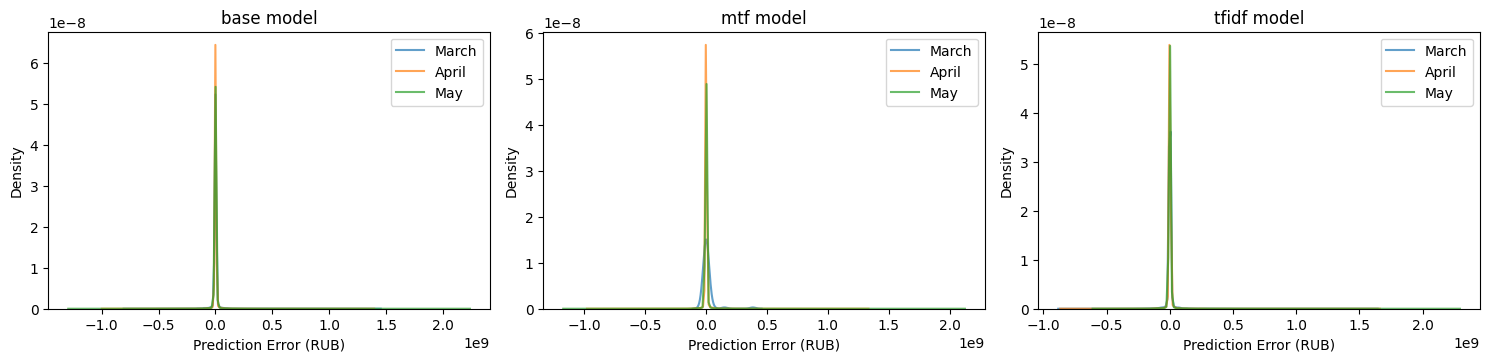

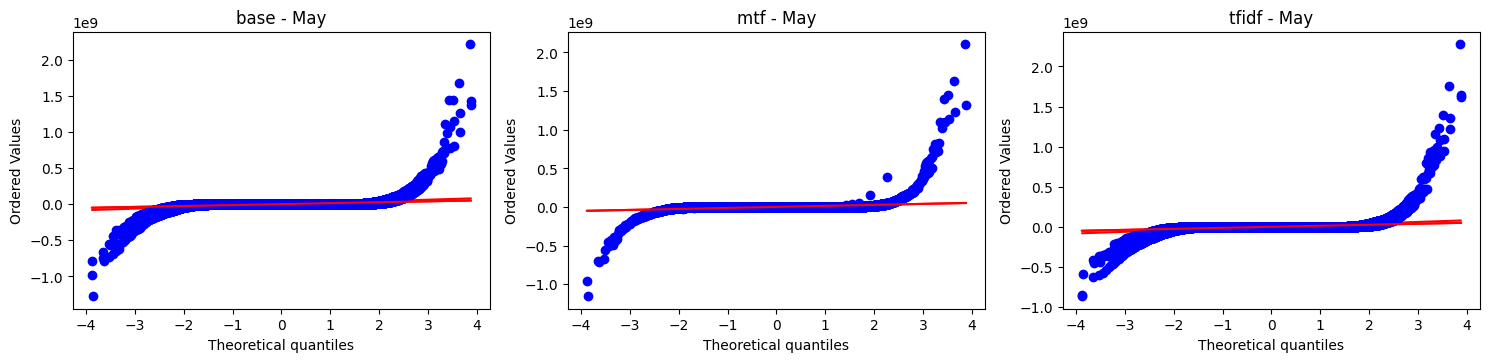


Distribution Shift Tests:
   Model      Comparison  KS Statistic  KS p-value  AD Statistic  \
0   base  March vs April        0.0253      0.0005       14.8935   
1   base    March vs May        0.0275      0.0002       20.7107   
2    mtf  March vs April        0.1996      0.0155        0.6391   
3    mtf    March vs May        0.2061      0.0112        1.1063   
4  tfidf  March vs April        0.0211      0.0061       10.1896   
5  tfidf    March vs May        0.0288      0.0001       19.1136   

   AD Critical (α=0.05)  Significant (α=0.05)  
0                 1.961                  True  
1                 1.961                  True  
2                 1.961                  True  
3                 1.961                  True  
4                 1.961                  True  
5                 1.961                  True  


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, anderson_ksamp

def plot_error_distributions(models_data):
    """Визуализация распределений ошибок по месяцам и моделям"""
    plt.figure(figsize=(15, 10))

    for i, model in enumerate(models, 1):
        plt.subplot(3, 3, i)
        for month in months:
            data = models_data[model][month]
            errors = (data['price'] - data['predicted_price']).dropna()
            sns.kdeplot(errors, label=f'{month}', alpha=0.7)
        plt.title(f'{model} model')
        plt.xlabel('Prediction Error (RUB)')
        plt.legend()

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/thesis/error_distributions.png')
    plt.show()

def qq_plot_comparison(models_data):
    """Q-Q графики для сравнения распределений ошибок с нормальным"""
    plt.figure(figsize=(15, 10))

    for i, model in enumerate(models, 1):
        plt.subplot(3, 3, i)
        for month in months:
            data = models_data[model][month]
            errors = (data['price'] - data['predicted_price']).dropna()
            stats.probplot(errors, dist="norm", plot=plt)
            plt.title(f'{model} - {month}')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/thesis/qq_plots.png')
    plt.show()

def test_distribution_shifts(models_data):
    """Статистические тесты на сдвиг распределений ошибок"""
    results = []

    for model in models:
        march_data = models_data[model]['March']
        march_errors = (march_data['price'] - march_data['predicted_price']).dropna()

        for month in ['April', 'May']:
            curr_data = models_data[model][month]
            curr_errors = (curr_data['price'] - curr_data['predicted_price']).dropna()

            # Тест Колмогорова-Смирнова
            ks_stat, ks_p = ks_2samp(march_errors, curr_errors)

            # Тест Андерсона-Дарлинга (более чувствителен к хвостам)
            try:
                ad_stat, ad_crit, ad_sig = anderson_ksamp([march_errors, curr_errors])
            except ValueError:
                ad_stat, ad_p = np.nan, np.nan

            # Добавляем округление до 4 знаков
            results.append({
                'Model': model,
                'Comparison': f'March vs {month}',
                'KS Statistic': round(ks_stat, 4),
                'KS p-value': round(ks_p, 4),
                'AD Statistic': round(ad_stat, 4) if not np.isnan(ad_stat) else np.nan,
                'AD Critical (α=0.05)': round(ad_crit[2], 4) if 'ad_crit' in locals() else np.nan,
                'Significant (α=0.05)': ks_p < 0.05 or ('ad_crit' in locals() and ad_stat > ad_crit[2])
            })

    return pd.DataFrame(results)

# Визуализация распределений ошибок
plot_error_distributions(models_data)

# Q-Q графики
qq_plot_comparison(models_data)

# Статистические тесты
distribution_tests = test_distribution_shifts(models_data)
print("\nDistribution Shift Tests:")
print(distribution_tests)

# Сохранение результатов тестов
distribution_tests.to_csv('distribution_shift_tests.csv', index=False)

### SHAP



Analyzing model: Base Model

1. Preparing data and calculating SHAP values...

2. Generating visualizations...
- Generating beeswarm plot...


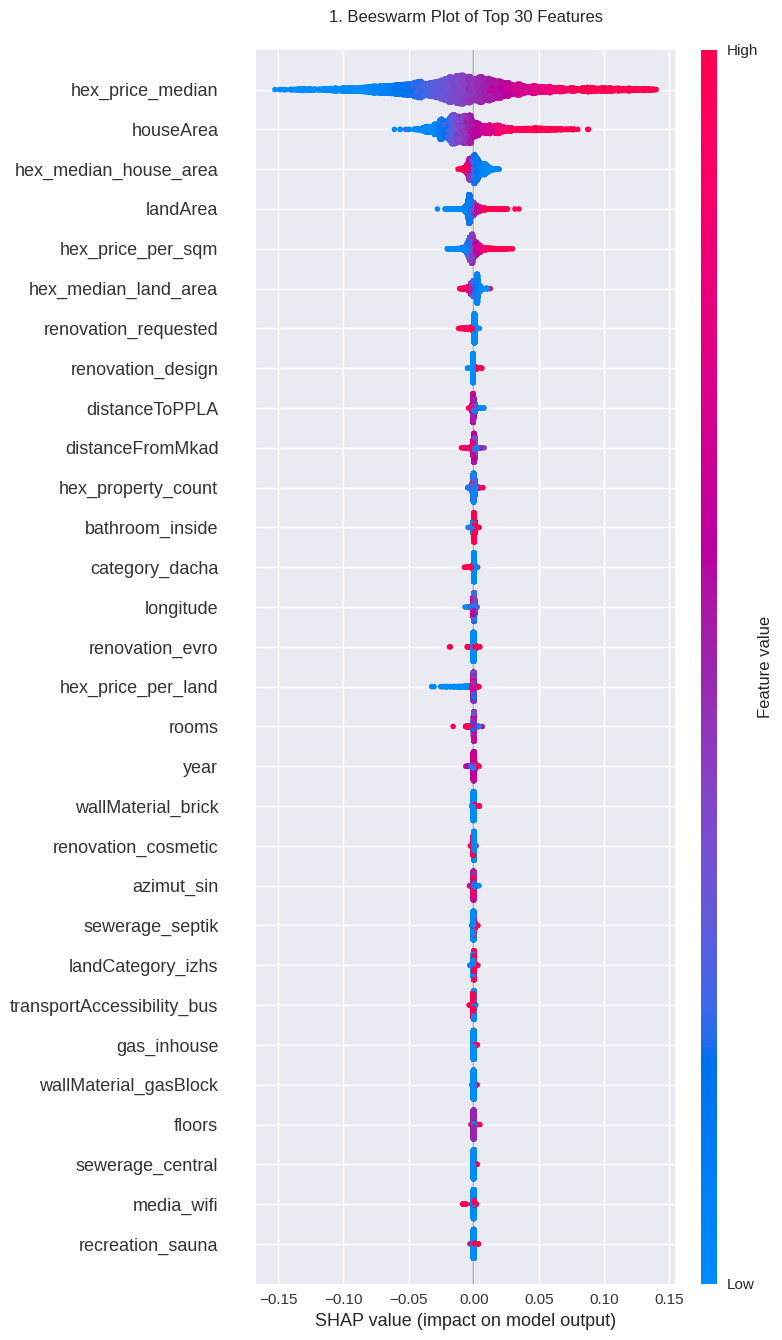

- Generating feature importance plot...


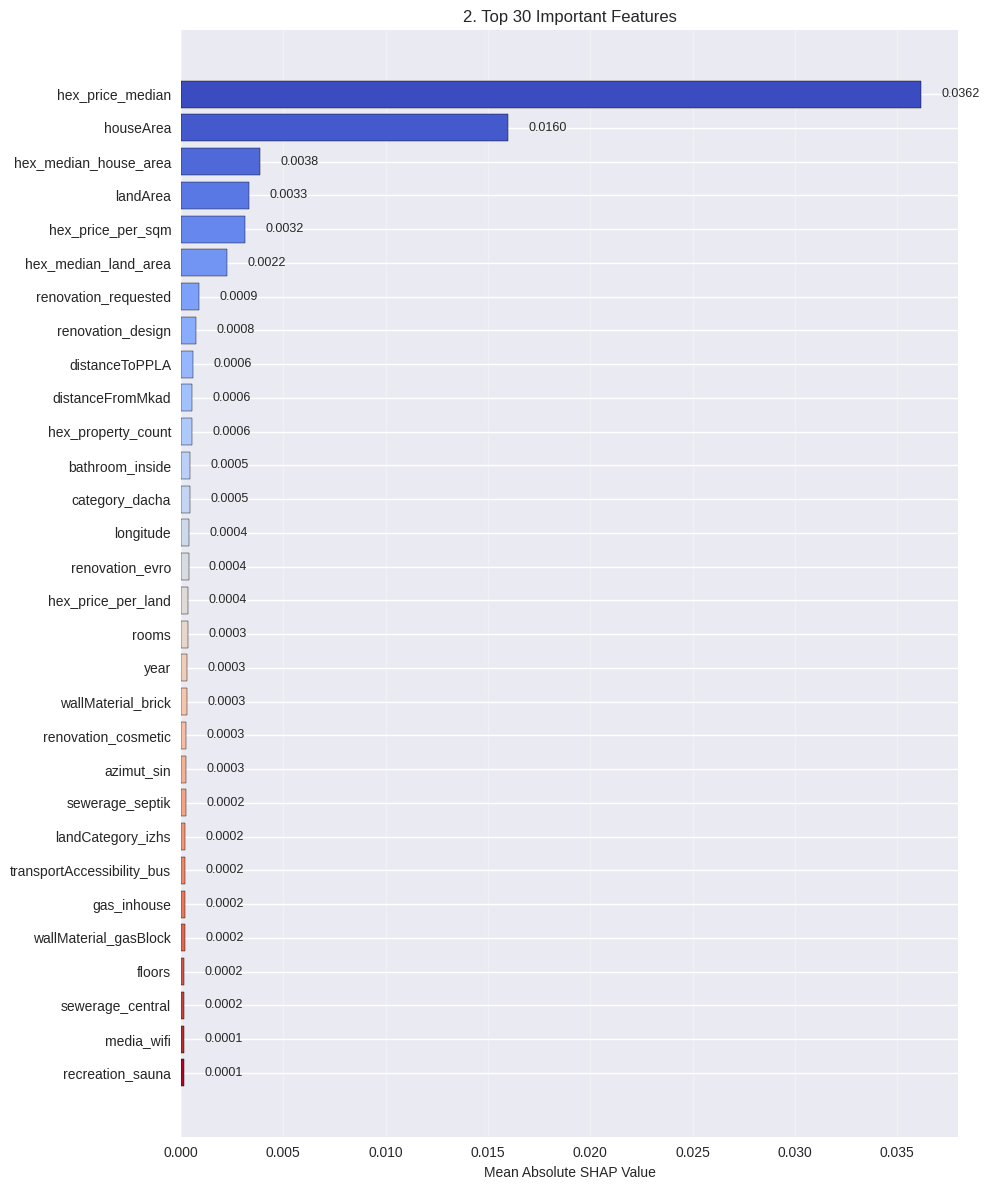


3. Generating tables...
- Displaying top features table...

Table 1: Top 30 Important Features


,Feature,SHAP Importance
153,hex_price_median,0.036166
1,houseArea,0.015971
154,hex_median_house_area,0.003847
2,landArea,0.003345
157,hex_price_per_sqm,0.003154
155,hex_median_land_area,0.002235
50,renovation_requested,0.000902
49,renovation_design,0.000756
8,distanceToPPLA,0.000580
5,distanceFromMkad,0.000563



5. Analyzing least important features...

Table 3: Least Important Features (Top 50)


,Feature,SHAP Importance
87,nearestPPLA2_Spas-Klepiki,0.00000000
34,landCategory_farm,0.00000000
12,yearIsNull,0.00000000
64,saleMethod_auction,0.00000000
65,saleMethod_part,0.00000000
73,region_Московская область,0.00000000
138,nearestPPLA2_Reutov,0.00000000
150,nearestPPLA2_Kimry,0.00000000
123,nearestPPLA2_Khimki,0.00000000
148,nearestPPLA2_Staritsa,0.00000000



Analysis complete!

Generating HTML report...

HTML report saved to: /content/model_report_Base Model.html

Analyzing model: MTF Model

1. Preparing data and calculating SHAP values...

2. Generating visualizations...
- Generating beeswarm plot...


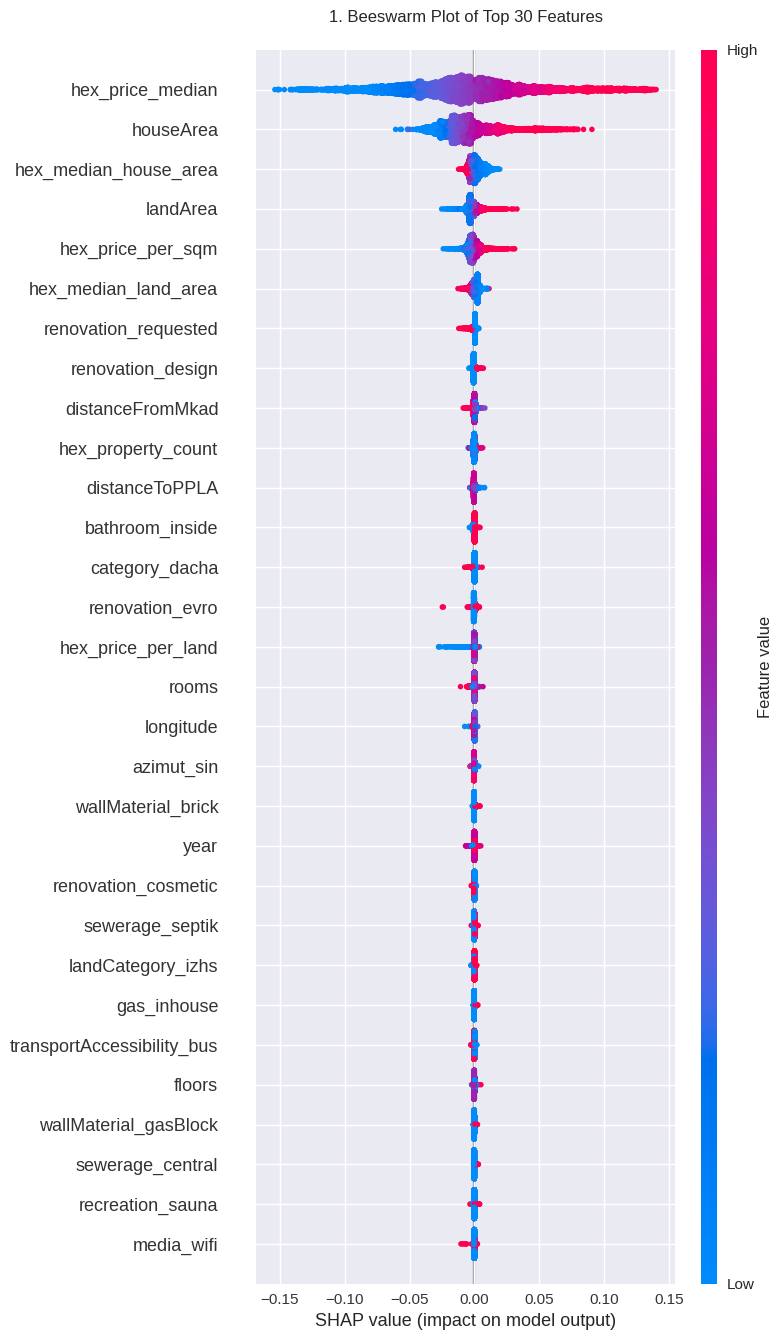

- Generating feature importance plot...


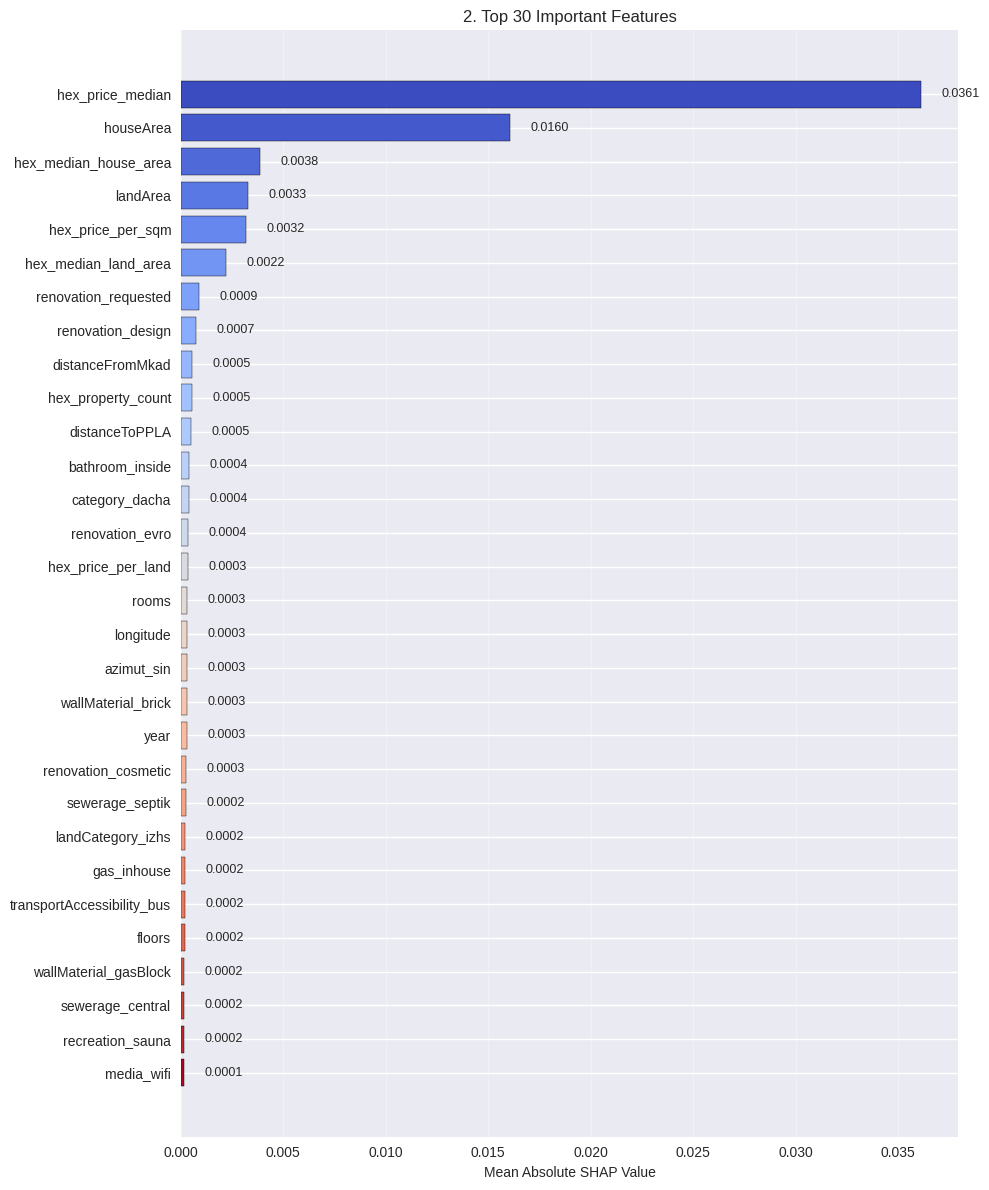


3. Generating tables...
- Displaying top features table...

Table 1: Top 30 Important Features


,Feature,SHAP Importance
170,hex_price_median,0.036126
1,houseArea,0.016042
171,hex_median_house_area,0.003847
2,landArea,0.003264
174,hex_price_per_sqm,0.003201
172,hex_median_land_area,0.002212
67,renovation_requested,0.000886
66,renovation_design,0.000733
5,distanceFromMkad,0.000530
173,hex_property_count,0.000524



4. Analyzing text features (text_)...

Text Features Statistics (text_):
- Total text features: 17
- Total importance: 0.0001
- Share of total importance: 0.1%
- Max importance: 0.0000
- Mean importance: 0.0000
- Generating text features plot...


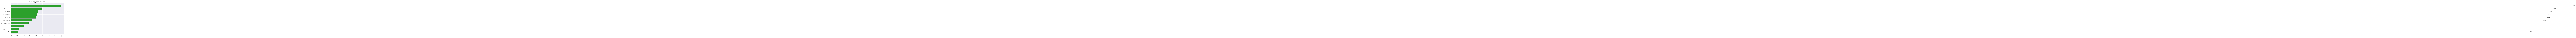

- Displaying text features table...

Table 2: Text Features Importance


,Feature,SHAP Importance
12,text_строится,0.000020
19,text_white box,0.000012
20,text_под снос,0.000011
15,text_без отделки,0.000010
27,text_срочно,0.000010
26,text_часть дома,0.000008
17,text_чистовая отделка,0.000007
22,text_старый,0.000005
23,text_садовой книжке,0.000003
28,text_обмен,0.000003


- Displaying text features examples...

Text Features Examples:
- text_строится
- text_white box
- text_под снос
- text_без отделки
- text_срочно
- text_часть дома
- text_чистовая отделка
- text_старый
- text_садовой книжке
- text_обмен

5. Analyzing least important features...

Table 3: Least Important Features (Top 50)


,Feature,SHAP Importance
157,nearestPPLA2_Iznoski,0.00000000
158,nearestPPLA2_Gus’-Khrustal’nyy,0.00000000
104,nearestPPLA2_Spas-Klepiki,0.00000000
29,yearIsNull,0.00000000
51,landCategory_farm,0.00000000
13,text_холодный контур,0.00000000
90,region_Московская область,0.00000000
21,text_ветхий,0.00000000
81,saleMethod_auction,0.00000000
160,nearestPPLA2_Mikhaylov,0.00000000



Analysis complete!

Generating HTML report...

HTML report saved to: /content/model_report_MTF Model.html

Analyzing model: TF-IDF Model

1. Preparing data and calculating SHAP values...

2. Generating visualizations...
- Generating beeswarm plot...


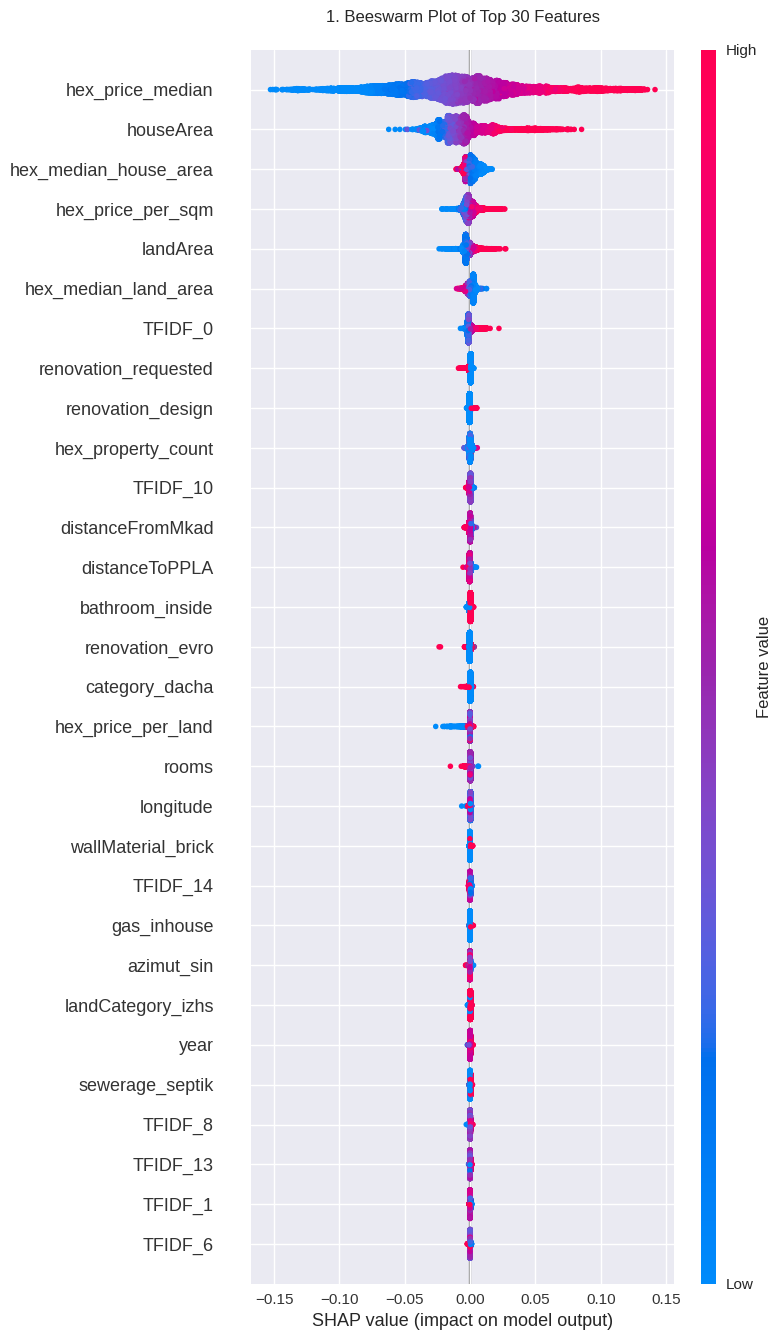

- Generating feature importance plot...


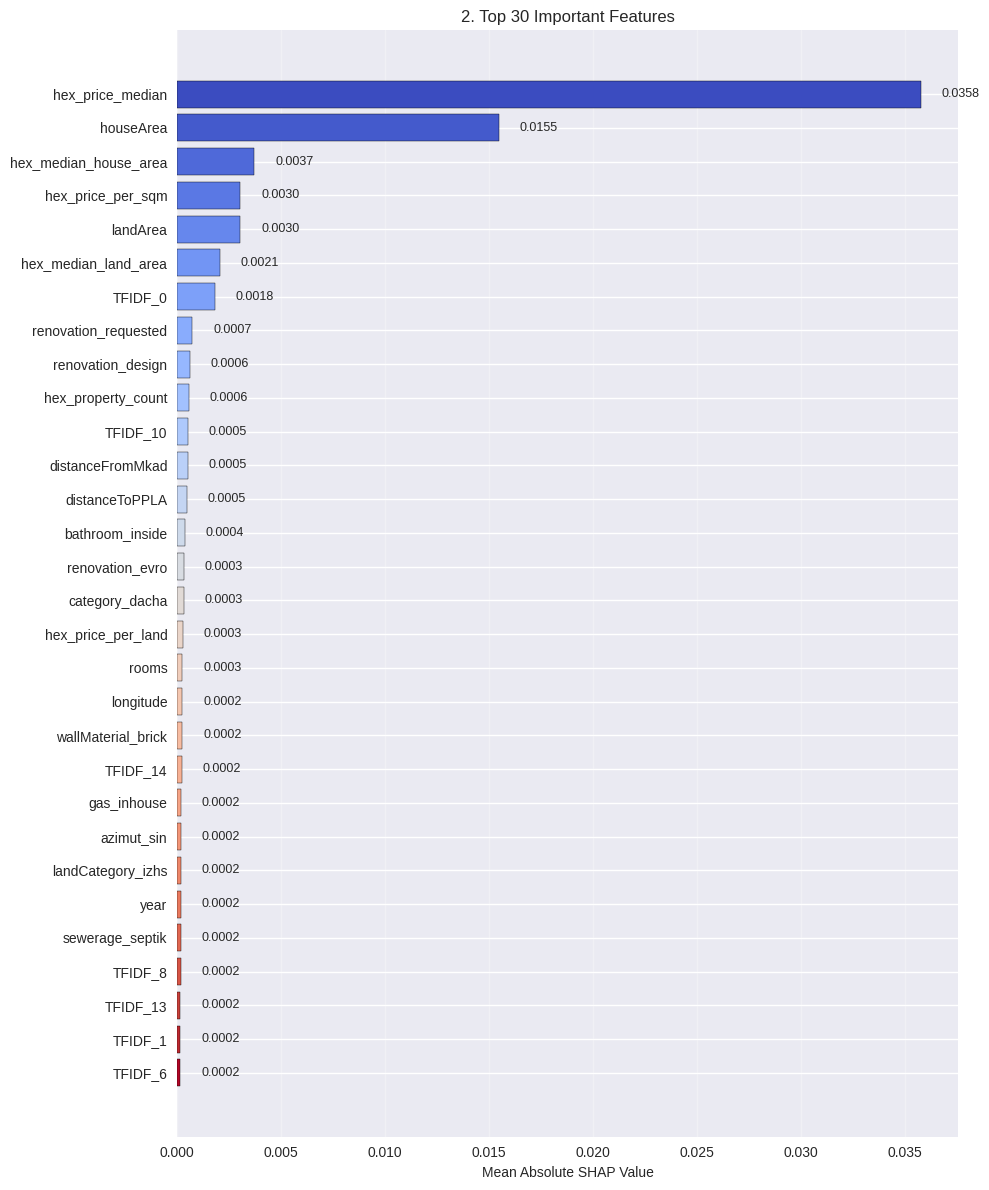


3. Generating tables...
- Displaying top features table...

Table 1: Top 30 Important Features


,Feature,SHAP Importance
153,hex_price_median,0.035795
1,houseArea,0.015471
154,hex_median_house_area,0.003721
157,hex_price_per_sqm,0.003048
2,landArea,0.003047
155,hex_median_land_area,0.002067
162,TFIDF_0,0.001817
50,renovation_requested,0.000733
49,renovation_design,0.000609
156,hex_property_count,0.000565



4. Analyzing text features (TFIDF_)...

Text Features Statistics (TFIDF_):
- Total text features: 100
- Total importance: 0.0080
- Share of total importance: 10.1%
- Max importance: 0.0018
- Mean importance: 0.0001
- Generating text features plot...


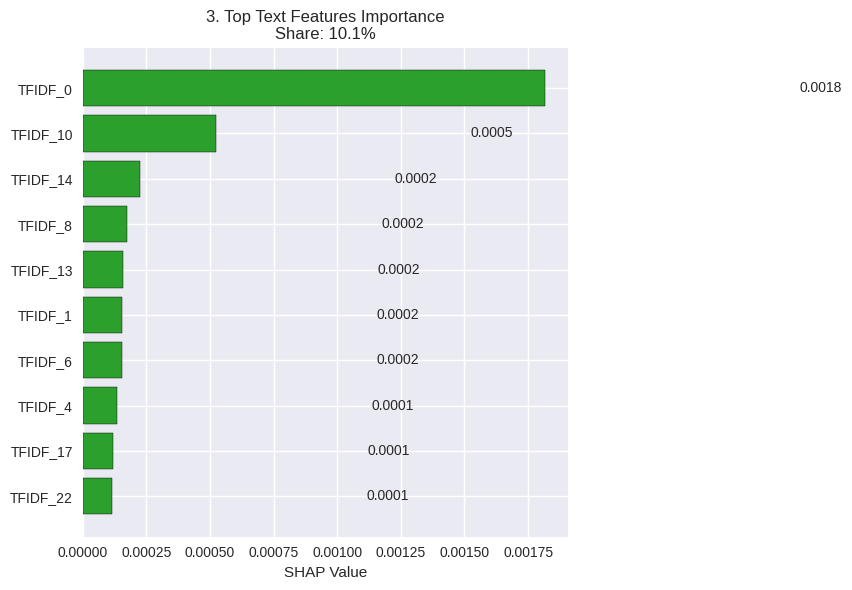

- Displaying text features table...

Table 2: Text Features Importance


,Feature,SHAP Importance
162,TFIDF_0,0.001817
172,TFIDF_10,0.000525
176,TFIDF_14,0.000226
170,TFIDF_8,0.000173
175,TFIDF_13,0.000159
163,TFIDF_1,0.000154
168,TFIDF_6,0.000153
166,TFIDF_4,0.000135
179,TFIDF_17,0.000121
184,TFIDF_22,0.000116


- Displaying text features examples...

Text Features Examples:
- TFIDF_0
- TFIDF_10
- TFIDF_14
- TFIDF_8
- TFIDF_13
- TFIDF_1
- TFIDF_6
- TFIDF_4
- TFIDF_17
- TFIDF_22

5. Analyzing least important features...

Table 3: Least Important Features (Top 50)


,Feature,SHAP Importance
87,nearestPPLA2_Spas-Klepiki,0.00000000
64,saleMethod_auction,0.00000000
141,nearestPPLA2_Gus’-Khrustal’nyy,0.00000000
146,nearestPPLA2_Sobinka,0.00000000
145,nearestPPLA2_Zhukov,0.00000000
143,nearestPPLA2_Mikhaylov,0.00000000
140,nearestPPLA2_Iznoski,0.00000000
148,nearestPPLA2_Staritsa,0.00000000
139,nearestPPLA2_Konakovo,0.00000000
12,yearIsNull,0.00000000



Analysis complete!

Generating HTML report...

HTML report saved to: /content/model_report_TF-IDF Model.html


In [48]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap



# Исправленная настройка стиля
plt.style.use('seaborn-v0_8')  # Новый корректный стиль для seaborn
red_blue_cmap = LinearSegmentedColormap.from_list('red_blue', ['#FF0000', '#0000FF'])


### текстовые фичи
def analyze_text_features_importance(importance_df, model_name, feature_prefix):
    """
    Анализирует важность текстовых фичей с заданным префиксом
    """
    # Фильтруем текстовые фичи
    text_features = importance_df[importance_df['Признак'].str.startswith(feature_prefix)]

    if len(text_features) == 0:
        print(f"\nВ модели {model_name} не найдено текстовых фичей с префиксом '{feature_prefix}'")
        return

    # Вычисляем суммарную важность текстовых фичей
    total_importance = importance_df['Важность (SHAP)'].sum()
    text_importance = text_features['Важность (SHAP)'].sum()
    text_share = text_importance / total_importance * 100

    print(f"\nАнализ текстовых фичей ({feature_prefix}) в модели {model_name}:")
    print(f"- Всего текстовых фичей: {len(text_features)}")
    print(f"- Суммарная важность: {text_importance:.4f}")
    print(f"- Доля от общей важности: {text_share:.1f}%")

    # Визуализация топ-10 текстовых фичей
    top_text_features = text_features.head(10)

    plt.figure(figsize=(10, 6))
    bars = plt.barh(top_text_features['Признак'], top_text_features['Важность (SHAP)'],
                   color='#1f77b4', edgecolor='black')

    plt.title(f"Топ-10 текстовых фичей ({feature_prefix}) в модели {model_name}\n"
             f"Общая доля важности: {text_share:.1f}%", fontsize=12)
    plt.xlabel('Важность (SHAP)')
    plt.gca().invert_yaxis()

    # Добавляем значения на график
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                f"{width:.4f}", va='center')

    plt.tight_layout()
    plt.show()

    return text_features

def compare_models_text_features(results):
    """
    Сравнивает важность текстовых фичей между моделями
    """
    comparison_data = []

    for model_name, df in results.items():
        if df is None:
            continue

        if model_name == "base":
            continue  # Пропускаем базовую модель

        prefix = "text_" if model_name == "mtf" else "TFIDF_"
        text_features = df[df['Признак'].str.startswith(prefix)]

        if len(text_features) > 0:
            total_importance = df['Важность (SHAP)'].sum()
            text_importance = text_features['Важность (SHAP)'].sum()
            share = text_importance / total_importance * 100

            comparison_data.append({
                'Модель': "MTF" if model_name == "mtf" else "TF-IDF",
                'Кол-во текстовых фичей': len(text_features),
                'Суммарная важность': text_importance,
                'Доля важности (%)': share,
                'Макс. важность': text_features['Важность (SHAP)'].max(),
                'Средняя важность': text_features['Важность (SHAP)'].mean()
            })

    if not comparison_data:
        print("Нет данных для сравнения текстовых фичей")
        return

    comparison_df = pd.DataFrame(comparison_data)

    # Визуализация сравнения
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # График 1: Доля важности
    axes[0].bar(comparison_df['Модель'], comparison_df['Доля важности (%)'],
               color=['#1f77b4', '#ff7f0e'])
    axes[0].set_title('Доля важности текстовых фичей')
    axes[0].set_ylabel('Доля от общей важности (%)')

    # График 2: Максимальная и средняя важность
    width = 0.35
    x = np.arange(len(comparison_df))
    axes[1].bar(x - width/2, comparison_df['Макс. важность'], width, label='Макс. важность')
    axes[1].bar(x + width/2, comparison_df['Средняя важность'], width, label='Средняя важность')
    axes[1].set_title('Максимальная и средняя важность')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(comparison_df['Модель'])
    axes[1].legend()

    plt.suptitle('Сравнение важности текстовых фичей между моделями', fontsize=14)
    plt.tight_layout()
    plt.show()

    return comparison_df


### основные фичи

def get_transformed_data(predictor, sample_size=500):
    """Улучшенная версия для работы с TF-IDF и другими трансформерами"""
    try:
        # Проверяем наличие пайплайна и шага 'features'
        if not hasattr(predictor, 'pipeline') or 'features' not in predictor.pipeline.named_steps:
            print("Пайплайн не найден или не содержит шага 'features'")
            return None, None

        ct = predictor.pipeline.named_steps['features']
        X_sample = predictor.last_prepared_input.iloc[:sample_size]

        # Преобразуем данные
        X_transformed = ct.transform(X_sample)

        # Получаем имена фичей
        feature_names = []

        if hasattr(ct, 'transformers_'):
            for name, trans, cols in ct.transformers_:
                if name == 'num_cat':
                    # Обработка числовых и категориальных фичей
                    if trans == 'passthrough':
                        if isinstance(cols, list):
                            feature_names.extend(cols)
                        else:
                            feature_names.append(str(cols))
                    elif hasattr(trans, 'get_feature_names_out'):
                        try:
                            feature_names.extend(trans.get_feature_names_out(cols))
                        except Exception:
                            n_out = trans.n_output_features_ if hasattr(trans, 'n_output_features_') else len(cols)
                            feature_names.extend([f"{name}_{i}" for i in range(n_out)])

                elif name == 'text':
                    # Специальная обработка для TF-IDF
                    n_tfidf_features = X_transformed.shape[1] - len(feature_names)

                    # Пробуем получить реальные n-граммы из TF-IDF
                    if hasattr(ct, 'named_transformers_') and 'text' in ct.named_transformers_:
                        tfidf = ct.named_transformers_['text']
                        if hasattr(tfidf, 'get_feature_names_out'):
                            try:
                                tfidf_names = tfidf.get_feature_names_out()
                                feature_names.extend([f"TFIDF_{n}" for n in tfidf_names[:n_tfidf_features]])
                            except Exception:
                                feature_names.extend([f"TFIDF_{i}" for i in range(n_tfidf_features)])
                        else:
                            feature_names.extend([f"TFIDF_{i}" for i in range(n_tfidf_features)])
                    else:
                        feature_names.extend([f"TFIDF_{i}" for i in range(n_tfidf_features)])

        # Проверяем соответствие размеров
        if len(feature_names) != X_transformed.shape[1]:
            print(f"Предупреждение: количество фичей ({X_transformed.shape[1]}) не совпадает с количеством имен ({len(feature_names)})")
            feature_names = [f"feature_{i}" for i in range(X_transformed.shape[1])]

        # Преобразуем разреженные матрицы
        if hasattr(X_transformed, 'toarray'):
            X_transformed = X_transformed.toarray()

        return X_transformed, feature_names

    except Exception as e:
        print(f"Ошибка при получении данных: {str(e)}")
        return None, None

def plot_top_features(shap_values, feature_names, title, top_n=30):
    """Визуализация топ-N признаков с красно-синей схемой"""
    # Вычисляем среднюю важность
    mean_abs_shap = np.abs(shap_values).mean(axis=0)

    # Выбираем топ-N признаков
    top_indices = np.argsort(mean_abs_shap)[-top_n:][::-1]
    top_shap_values = mean_abs_shap[top_indices]
    top_features = [feature_names[i] for i in top_indices]

    # Нормализуем для цветовой карты
    norm_shap = top_shap_values / np.max(top_shap_values)

    # Создаем фигуру
    fig, ax = plt.subplots(figsize=(10, 12))

    # Горизонтальная бар-диаграмма
    bars = ax.barh(range(top_n), top_shap_values,
                  color=red_blue_cmap(norm_shap),
                  edgecolor='black', linewidth=0.5)

    # Добавляем значения
    for i, (bar, val) in enumerate(zip(bars, top_shap_values)):
        ax.text(val + 0.01, i, f"{val:.4f}", va='center', fontsize=9)

    # Настройки графика
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(top_features, fontsize=10)
    ax.set_title(f"Топ-{top_n} важных признаков: {title}", fontsize=12, pad=20)
    ax.set_xlabel("Средняя абсолютная величина SHAP значения", fontsize=10)
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

    return top_features, top_shap_values


import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import HTML

def analyze_model(predictor, model_name, sample_size=12000, top_n=50, bottom_n=50):
    """Complete model analysis with SHAP values including HTML report and notebook display

    Parameters:
    -----------
    predictor : model object
        Trained predictor model
    model_name : str
        Model name for display
    sample_size : int, optional
        Number of samples for SHAP calculation (default 500)
    top_n : int, optional
        Number of top features to display (default 30)
    bottom_n : int, optional
        Number of least important features to display (default 20)

    Returns:
    --------
    HTML
        Generated HTML report
    pd.DataFrame
        DataFrame with feature importances
    """

    # Initialize HTML report
    html_report = f"""
    <html>
    <head>
        <title>Model Analysis Report: {model_name}</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; }}
            h1, h2, h3 {{ color: #2c3e50; }}
            .plot {{ margin: 20px 0; }}
            table {{ border-collapse: collapse; margin: 15px 0; width: 100%; }}
            th, td {{ padding: 8px; text-align: left; border-bottom: 1px solid #ddd; }}
            tr:hover {{ background-color: #f5f5f5; }}
            .dataframe {{ width: 100%; margin-bottom: 20px; }}
        </style>
    </head>
    <body>
        <h1>Model Analysis Report: {model_name}</h1>
    """

    print(f"\n{'='*50}")
    print(f"Analyzing model: {model_name}")
    print(f"{'='*50}\n")

    # 1. Get transformed data and SHAP values
    print("1. Preparing data and calculating SHAP values...")
    html_report += "<h2>1. Data Preparation</h2>"
    X_transformed, feature_names = get_transformed_data(predictor, sample_size)
    if X_transformed is None:
        error_msg = "Error: Could not get transformed data"
        print(error_msg)
        html_report += f"<p>{error_msg}</p>"
        return HTML(html_report + "</body></html>"), None

    try:
        explainer = shap.TreeExplainer(predictor.pipeline.named_steps['model'])
        shap_values = explainer.shap_values(X_transformed)
        if isinstance(shap_values, list):
            shap_values = shap_values[0]
    except Exception as e:
        error_msg = f"Error calculating SHAP values: {str(e)}"
        print(error_msg)
        html_report += f"<p>{error_msg}</p>"
        return HTML(html_report + "</body></html>"), None

    # Calculate feature importance
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP Importance': mean_abs_shap
    }).sort_values('SHAP Importance', ascending=False)

    # 2. Visualizations
    print("\n2. Generating visualizations...")
    html_report += "<h2>2. Visualizations</h2>"

    # Plot 1: Beeswarm plot
    print("- Generating beeswarm plot...")
    html_report += "<h3>Plot 1: Beeswarm Plot (Top Features)</h3>"
    plt.figure(figsize=(10, 12))
    shap.summary_plot(shap_values, X_transformed,
                     feature_names=feature_names,
                     max_display=top_n,
                     show=False)
    plt.title(f"1. Beeswarm Plot of Top {top_n} Features", fontsize=12, pad=20)
    plt.tight_layout()
    beeswarm_path = f"beeswarm_{model_name}.png"
    plt.savefig(beeswarm_path, bbox_inches='tight', dpi=100)
    plt.close()
    html_report += f'<div class="plot"><img src="{beeswarm_path}" width="800"></div>'

    # Display in notebook
    plt.figure(figsize=(10, 12))
    shap.summary_plot(shap_values, X_transformed,
                     feature_names=feature_names,
                     max_display=top_n,
                     show=False)
    plt.title(f"1. Beeswarm Plot of Top {top_n} Features", fontsize=12, pad=20)
    plt.tight_layout()
    plt.show()

    # Plot 2: Horizontal bar chart (top features)
    print("- Generating feature importance plot...")
    html_report += "<h3>Plot 2: Top Features Importance</h3>"
    top_features = importance_df.head(top_n)
    plt.figure(figsize=(10, 12))
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(top_features)))
    bars = plt.barh(range(len(top_features)), top_features['SHAP Importance'],
                   color=colors, edgecolor='black')

    plt.yticks(range(len(top_features)), top_features['Feature'], fontsize=10)
    plt.title(f"2. Top {top_n} Important Features", fontsize=12)
    plt.xlabel("Mean Absolute SHAP Value", fontsize=10)

    for i, (bar, val) in enumerate(zip(bars, top_features['SHAP Importance'])):
        plt.text(val + 0.001, i, f"{val:.4f}", va='center', fontsize=9)

    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    top_features_path = f"top_features_{model_name}.png"
    plt.savefig(top_features_path, bbox_inches='tight', dpi=100)
    plt.close()
    html_report += f'<div class="plot"><img src="{top_features_path}" width="800"></div>'

    # Display in notebook
    plt.figure(figsize=(10, 12))
    bars = plt.barh(range(len(top_features)), top_features['SHAP Importance'],
                   color=colors, edgecolor='black')
    plt.yticks(range(len(top_features)), top_features['Feature'], fontsize=10)
    plt.title(f"2. Top {top_n} Important Features", fontsize=12)
    plt.xlabel("Mean Absolute SHAP Value", fontsize=10)
    for i, (bar, val) in enumerate(zip(bars, top_features['SHAP Importance'])):
        plt.text(val + 0.001, i, f"{val:.4f}", va='center', fontsize=9)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 3. Tables
    print("\n3. Generating tables...")
    html_report += "<h2>3. Feature Importance Tables</h2>"

    # Table 1: Top features table
    print("- Displaying top features table...")
    html_report += "<h3>Table 1: Top Important Features</h3>"
    styled_top = top_features.style\
        .background_gradient(cmap='coolwarm', subset=['SHAP Importance'])\
        .format({'SHAP Importance': "{:.6f}"})\
        .set_properties(**{'font-size': '10pt'})
    html_report += styled_top.to_html()

    # Display in notebook
    print(f"\nTable 1: Top {top_n} Important Features")
    display(styled_top)

    # Text features analysis
    text_prefix = "text_" if model_name == "MTF Model" else "TFIDF_" if model_name == "TF-IDF Model" else None

    if text_prefix:
        print(f"\n4. Analyzing text features ({text_prefix})...")
        text_features = importance_df[importance_df['Feature'].str.startswith(text_prefix)]

        if not text_features.empty:
            total_importance = importance_df['SHAP Importance'].sum()
            text_stats = {
                'count': len(text_features),
                'total_importance': text_features['SHAP Importance'].sum(),
                'share': (text_features['SHAP Importance'].sum() / total_importance) * 100,
                'max': text_features['SHAP Importance'].max(),
                'mean': text_features['SHAP Importance'].mean()
            }

            html_report += f"""
            <h2>4. Text Features Analysis ({text_prefix})</h2>
            <h3>Text Features Statistics</h3>
            <ul>
                <li>Total text features: {text_stats['count']}</li>
                <li>Total importance: {text_stats['total_importance']:.4f}</li>
                <li>Share of total importance: {text_stats['share']:.1f}%</li>
                <li>Max importance: {text_stats['max']:.4f}</li>
                <li>Mean importance: {text_stats['mean']:.4f}</li>
            </ul>
            """

            # Display stats in notebook
            print(f"\nText Features Statistics ({text_prefix}):")
            print(f"- Total text features: {text_stats['count']}")
            print(f"- Total importance: {text_stats['total_importance']:.4f}")
            print(f"- Share of total importance: {text_stats['share']:.1f}%")
            print(f"- Max importance: {text_stats['max']:.4f}")
            print(f"- Mean importance: {text_stats['mean']:.4f}")

            # Plot 3: Text features importance
            print("- Generating text features plot...")
            html_report += "<h3>Plot 3: Top Text Features Importance</h3>"
            top_text = text_features.head(10)
            plt.figure(figsize=(10, 6))
            bars = plt.barh(top_text['Feature'], top_text['SHAP Importance'],
                          color='#2ca02c', edgecolor='black')

            plt.title(f"3. Top Text Features Importance\nShare: {text_stats['share']:.1f}%", fontsize=12)
            plt.xlabel('SHAP Value')

            for bar in bars:
                width = bar.get_width()
                plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                        f"{width:.4f}", va='center')

            plt.gca().invert_yaxis()
            plt.tight_layout()
            text_plot_path = f"text_features_{model_name}.png"
            plt.savefig(text_plot_path, bbox_inches='tight', dpi=100)
            plt.close()
            html_report += f'<div class="plot"><img src="{text_plot_path}" width="800"></div>'

            # Display in notebook
            plt.figure(figsize=(10, 6))
            bars = plt.barh(top_text['Feature'], top_text['SHAP Importance'],
                          color='#2ca02c', edgecolor='black')
            plt.title(f"3. Top Text Features Importance\nShare: {text_stats['share']:.1f}%", fontsize=12)
            plt.xlabel('SHAP Value')
            for bar in bars:
                width = bar.get_width()
                plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                        f"{width:.4f}", va='center')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()

            # Table 2: Text features table
            print("- Displaying text features table...")
            html_report += "<h3>Table 2: Text Features Importance</h3>"
            styled_text = text_features.style\
                .background_gradient(cmap='Greens', subset=['SHAP Importance'])\
                .format({'SHAP Importance': "{:.6f}"})\
                .set_properties(**{'font-size': '10pt'})
            html_report += styled_text.to_html()

            # Display in notebook
            print("\nTable 2: Text Features Importance")
            display(styled_text)

            # Text features examples
            print("- Displaying text features examples...")
            html_report += "<h3>Text Features Examples</h3>"
            examples = text_features['Feature'].head(10).tolist()
            html_report += "<ul>"
            for example in examples:
                html_report += f"<li>{example}</li>"
            html_report += "</ul>"

            # Display in notebook
            print("\nText Features Examples:")
            for example in examples:
                print(f"- {example}")

    # 5. Least important features
    print("\n5. Analyzing least important features...")
    html_report += "<h2>5. Least Important Features</h2>"
    html_report += "<h3>Table 3: Least Important Features</h3>"
    bottom_features = importance_df.sort_values('SHAP Importance').head(bottom_n)

    if not bottom_features.empty:
        styled_bottom = bottom_features.style\
            .background_gradient(cmap='Reds_r', subset=['SHAP Importance'])\
            .format({'SHAP Importance': "{:.8f}"})\
            .set_properties(**{
                'font-size': '10pt',
                'text-overflow': 'ellipsis',
                'max-width': '400px'
            })
        html_report += styled_bottom.to_html()

        # Display in notebook
        print(f"\nTable 3: Least Important Features (Top {bottom_n})")
        display(styled_bottom)
    else:
        html_report += "<p>No data on least important features</p>"
        print("\nNo data on least important features")

    # Complete and display HTML report
    html_report += "</body></html>"

    print("\nAnalysis complete!")
    print("\nGenerating HTML report...")

    report_filename = f"model_report_{model_name}.html"
    with open(report_filename, "w", encoding="utf-8") as f:
        f.write(html_report)
    print(f"\nHTML report saved to: {os.path.abspath(report_filename)}")

    return HTML(html_report), importance_df

# Анализ всех моделей (ограничиваем до топ-30)
results = {}

# 1. Базовая модель
if hasattr(predictor_base, 'pipeline'):
    results['base'] = analyze_model(predictor_base, "Base Model", top_n=30)

# 2. MTF модель
if hasattr(predictor_mtf, 'pipeline'):
    results['mtf'] = analyze_model(predictor_mtf, "MTF Model", top_n=30)

# 3. TF-IDF модель
if hasattr(predictor_tfidf, 'pipeline'):
    results['tfidf'] = analyze_model(predictor_tfidf, "TF-IDF Model", top_n=30)

In [50]:
def generate_full_shap_tables(results):
    """
    Генерирует полные таблицы с SHAP-важностью для всех фичей всех моделей
    Возвращает словарь с DataFrame для каждой модели
    """
    full_shap_tables = {}

    for model_name, (html_report, importance_df) in results.items():
        if importance_df is not None:
            # Создаем полную копию DataFrame без ограничений по top_n
            full_df = importance_df.copy()

            # Добавляем нормализованную важность (0-1)
            full_df['Normalized Importance'] = (full_df['SHAP Importance'] - full_df['SHAP Importance'].min()) / \
                                             (full_df['SHAP Importance'].max() - full_df['SHAP Importance'].min())

            # Добавляем ранк фичи
            full_df['Rank'] = range(1, len(full_df)+1)

            # Переименовываем колонки для удобства
            full_df = full_df.rename(columns={
                'Feature': 'Feature Name',
                'SHAP Importance': 'SHAP Value'
            })

            # Сохраняем в словарь
            full_shap_tables[model_name] = full_df

            # Сохраняем в CSV
            csv_filename = f"full_shap_{model_name}.csv"
            full_df.to_csv(csv_filename, index=False)
            print(f"Полная таблица SHAP-значений для модели {model_name} сохранена в {csv_filename}")

    return full_shap_tables

# Генерируем полные таблицы
full_shap_tables = generate_full_shap_tables(results)

# Пример доступа к таблицам:
# full_shap_tables['base']  # Для базовой модели
# full_shap_tables['mtf']   # Для MTF модели
# full_shap_tables['tfidf'] # Для TF-IDF модели

Полная таблица SHAP-значений для модели base сохранена в full_shap_base.csv
Полная таблица SHAP-значений для модели mtf сохранена в full_shap_mtf.csv
Полная таблица SHAP-значений для модели tfidf сохранена в full_shap_tfidf.csv
